# [Dataset Experiment & Model Selection]

In this notebook, user can compare datasets according to preprocessing steps.  

comparison :
- combination of features (9 cases)
- dataset according to preprocessing stages
- 10 algorithms

## Import Library, Module

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import pickle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from xgboost import plot_tree
from sklearn.tree import plot_tree

In [4]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg
from sklearn.svm import SVR
import lightgbm as ltb

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model  # linear, Lasso

import catboost as cb

---
## Data Load

In [5]:
# set the route for dataset
# route = "./2023_KSW_Fall_program_final_team_HoT/4+6_Imputation+5_Feature_Scaling(final_dataset).csv"

route = "./Dataset/2023_KSW_Fall_program_final_team_HoT/4+6_Imputation+5_Feature_Scaling(final_dataset).csv"

# set ratio for splitting train/test dataset
test_size = 0.33
shuffle = True

# set the K for cross-validation
k_splits = 10

In [6]:
# data_load function for preparing dataset
# user can remove the specific feature by setting remove_list parameter

def data_loader(route, remove_list):
    # load dataset from route user set above
    original_data = pd.read_csv(route, encoding='unicode_escape')
    
    # drop index
    original_data = original_data.drop(original_data.columns[0], axis=1)
    
    # drop timestamps (depending on dataset, there is timestamp column)
    # original_data = original_data.drop(original_data.columns[0], axis=1)

    # drop features in remove_list
    for i in remove_list:
        original_data = original_data.drop([i], axis=1)
    
    # drop Nan values - feature by feature
    original_data = original_data.dropna()
    
    # check data shape
    print(original_data.shape)
    
    # set x, y dataset
    # y is the SP ratio, which is the target
    y = original_data[['SP ratio']].squeeze().to_numpy()
    x = original_data.drop(['SP ratio'], axis=1).to_numpy()
    
    return x, y

---
## Model Define

In [7]:
adaboost = AdaBoostRegressor()
rf = RandomForestRegressor()
knn = KNeighborsRegressor()
gbr = GradientBoostingRegressor()
xgb = xg.XGBRegressor()
svr = SVR()
lgbr = ltb.LGBMRegressor()
gnb = GaussianNB()
etr = ExtraTreesRegressor()

---
## Features Selection

In [9]:
# hr, hrv, coherence, BM, sleep, eda, temperature
feature_1 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention']
x_1, y_1 = data_loader(route, feature_1)

# hr, hrv, BM, sleep, eda, temperature
feature_2 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence']
x_2, y_2 = data_loader(route, feature_2)

# hr, hrv, sleep, eda, temperature
feature_3 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence' ,'BM']
x_3, y_3 = data_loader(route, feature_3)

# hr, hrv, BM, eda, temperature
feature_4 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence' ,'sleep']
x_4, y_4 = data_loader(route, feature_4)

# hr, hrv, eda, temperature
feature_5 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence' ,'sleep', 'BM']
x_5, y_5 = data_loader(route, feature_5)

# hr, hrv, temperature
feature_6 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence' ,'sleep', 'BM', 'eda']
x_6, y_6 = data_loader(route, feature_6)

# hr, hrv, eda
feature_7 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'coherence' ,'sleep', 'BM', 'temperature']
x_7, y_7 = data_loader(route, feature_7)

# hr, hrv, coherence, BM, sleep, eda
feature_8 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'temperature']
x_8, y_8 = data_loader(route, feature_8)

# hr, hrv, coherence, BM, sleep, temperature
feature_9 = ['alpha_wave', 'beta_wave', 'theta_wave', 'delta_wave', 'gamma_wave', 'attention', 'eda']
x_9, y_9 = data_loader(route, feature_9)

(12358, 8)
(12358, 7)
(12358, 6)
(12358, 6)
(12358, 5)
(12358, 4)
(12358, 4)
(12358, 7)
(12358, 7)


---
## Model Training

In [10]:
# create KFold object for cross validation

k_fold = KFold(n_splits=k_splits, random_state=1, shuffle=True)

In [11]:
# training 1 model

def model_trainer(model, X_train, X_test, y_train, y_test):
    i=1
    
    # create lists for 3 types of metrics
    r2_scr = []
    rmse_scr = []
    mae_scr = []
    
    # Splitting train dataset into train, valid dataset using k-fold
    for train_index, val_index in k_fold.split(np.zeros(len(X_train)), y_train):
        X_train_fold, X_val_fold = X_train[train_index,:], X_train[val_index,:]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
        # fit the regressor with x and y data
        model.fit(X_train_fold, y_train_fold)

        # validation for model with validation dataset
        val_labels = np.expm1(y_val_fold)
        val_pred = np.expm1(model.predict(X_val_fold))
        
        # appending evluation values for each fold 
        r2_scr.append(r2_score(val_labels, val_pred))
        mae_scr.append(mean_absolute_error(val_labels, val_pred))
        rmse_scr.append(mean_squared_error(val_labels, val_pred, squared=False))

        i+=1
        
    # return model and evaluation metrics as a mean value exept r2 (to draw graph)    
    return model, r2_scr, np.average(mae_scr), np.average(rmse_scr)

In [12]:
def training(X_train, X_test, y_train, y_test):
    
    # Model load
    adaboost = AdaBoostRegressor()
    rf = RandomForestRegressor()
    knn = KNeighborsRegressor()
    gbr = GradientBoostingRegressor()
    xgb = xg.XGBRegressor()
    svr = SVR()
    lgbr = ltb.LGBMRegressor()
    etr = ExtraTreesRegressor()
    dt = DecisionTreeRegressor()
    rd = Ridge()
    
    # model training
    adaboost, r2_ada, mae_ada, rmse_ada = model_trainer(adaboost, X_train, X_test, y_train, y_test)
    rf, r2_rf, mae_rf, rmse_rf = model_trainer(rf, X_train, X_test, y_train, y_test)
    knn, r2_knn, mae_knn, rmse_knn = model_trainer(knn, X_train, X_test, y_train, y_test)
    gbr, r2_gbr, mae_gbr, rmse_gbr = model_trainer(gbr, X_train, X_test, y_train, y_test)
    xgb, r2_xgb, mae_xgb, rmse_xgb = model_trainer(xgb, X_train, X_test, y_train, y_test)
    svr, r2_svr, mae_svr, rmse_svr = model_trainer(svr, X_train, X_test, y_train, y_test)
    lgbr, r2_lgbr, mae_lgbr, rmse_lgbr = model_trainer(lgbr, X_train, X_test, y_train, y_test)
    etr, r2_etr, mae_etr, rmse_etr = model_trainer(etr, X_train, X_test, y_train, y_test)
    dt, r2_dt, mae_dt, rmse_dt = model_trainer(dt, X_train, X_test, y_train, y_test)
    rd, r2_rd, mae_rd, rmse_rd = model_trainer(rd, X_train, X_test, y_train, y_test)
    
    # set the x axis for plot
    x = np.arange(k_splits)
  
    # Visualizing by making plot 10 models' R-Squared score trends for each fold
    plt.plot(x, r2_ada, label = "adaboost") 
    plt.plot(x, r2_rf, label = "random_forest") 
    plt.plot(x, r2_knn, label = "knn") 
    plt.plot(x, r2_gbr, label = "gbr")
    plt.plot(x, r2_xgb, label = "xgb")
    plt.plot(x, r2_svr, label = "svr")
    plt.plot(x, r2_lgbr, label = "lgbr")
    plt.plot(x, r2_etr, label = "etr")
    plt.plot(x, r2_dt, label = "dt")
    plt.plot(x, r2_rd, label = "rd")
    plt.legend() 
    plt.show()
    
    # store models
    models = [adaboost, rf, knn, gbr, xgb, svr, lgbr, etr, dt, rd]
    
    # store each metrics for each model
    r2 = [r2_ada, r2_rf, r2_knn, r2_gbr, r2_xgb, r2_svr, r2_lgbr, r2_etr, r2_dt, r2_rd]
    mae = [mae_ada, mae_rf, mae_knn, mae_gbr, mae_xgb, mae_svr, mae_lgbr, mae_etr, mae_dt, mae_rd]
    rmse = [rmse_ada, rmse_rf, rmse_knn, rmse_gbr, rmse_xgb, rmse_svr, rmse_lgbr, rmse_etr, rmse_dt, rmse_rd]
    
    # return each metrics as a mean values and models
    return models, np.mean(r2 , axis=1), mae, rmse

---
## Experiments

#### Case 1 : hr, hrv, coherence, BM, sleep, eda, temperature

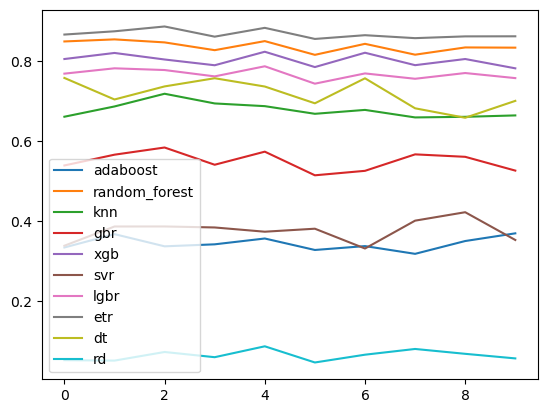

In [13]:
# Dataset Split to Train/Test data

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size = test_size, shuffle = shuffle)

models_1, r2_score_1, mae_score_1, rmse_score_1 = training(X_train_1, X_test_1, y_train_1, y_test_1)

#### Case 2 : hr, hrv, BM, sleep, eda, temperature

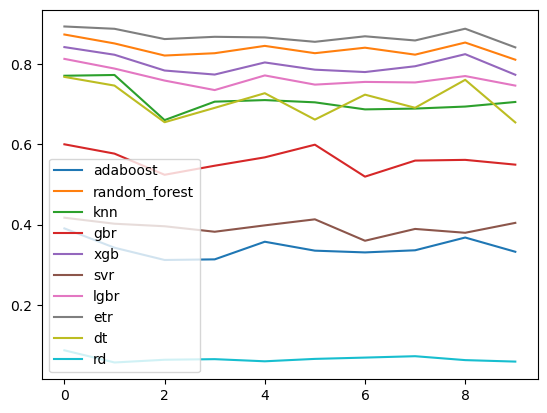

In [15]:
# Dataset Split to Train/Test data

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size = test_size, shuffle = shuffle)

models_2, r2_score_2, mae_score_2, rmse_score_2 = training(X_train_2, X_test_2, y_train_2, y_test_2)

#### Case 3 : hr, hrv, sleep, eda, temperature

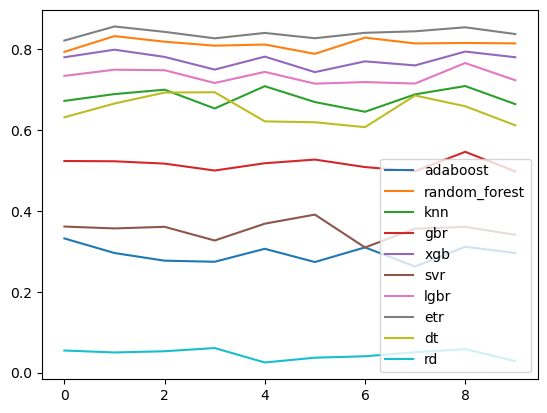

In [16]:
# Dataset Split to Train/Test data

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, test_size = test_size, shuffle = shuffle)

models_3, r2_score_3, mae_score_3, rmse_score_3 = training(X_train_3, X_test_3, y_train_3, y_test_3)

#### Case 4 : hr, hrv, BM, eda, temperature

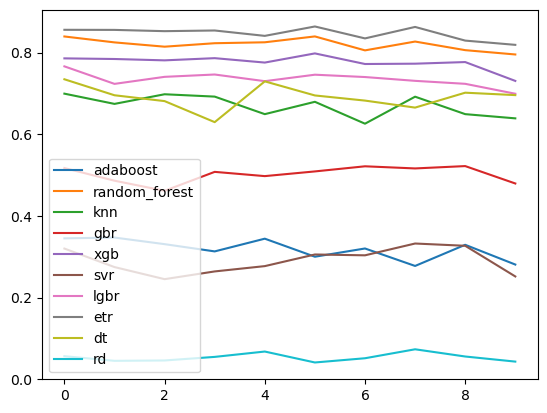

In [17]:
# Dataset Split to Train/Test data

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(x_4, y_4, test_size = test_size, shuffle = shuffle)

models_4, r2_score_4, mae_score_4, rmse_score_4 = training(X_train_4, X_test_4, y_train_4, y_test_4)

#### Case 5 : hr, hrv, eda, temperature

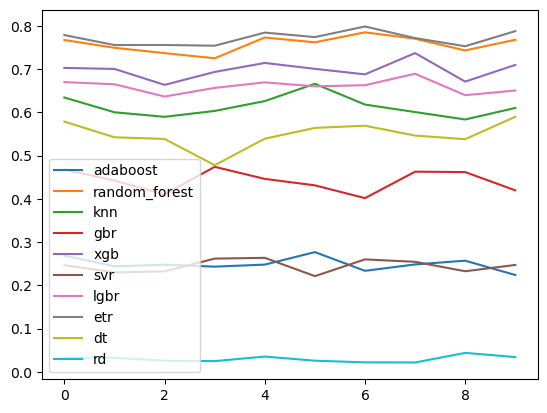

In [18]:
# Dataset Split to Train/Test data

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(x_5, y_5, test_size = test_size, shuffle = shuffle)

models_5, r2_score_5, mae_score_5, rmse_score_5 = training(X_train_5, X_test_5, y_train_5, y_test_5)

#### Case 6 : hr, hrv, temperature

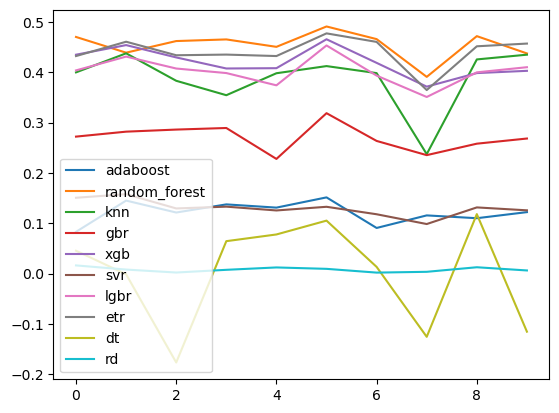

In [19]:
# Dataset Split to Train/Test data

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(x_6, y_6, test_size = test_size, shuffle = shuffle)

models_6, r2_score_6, mae_score_6, rmse_score_6 = training(X_train_6, X_test_6, y_train_6, y_test_6)

#### Case 7 : hr, hrv, eda

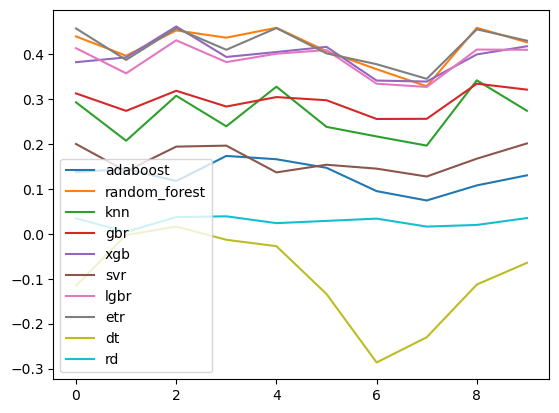

In [20]:
# Dataset Split to Train/Test data

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(x_7, y_7, test_size = test_size, shuffle = shuffle)

models_7, r2_score_7, mae_score_7, rmse_score_7 = training(X_train_7, X_test_7, y_train_7, y_test_7)

#### Case 8 : hr, hrv, coherence, BM, sleep, eda

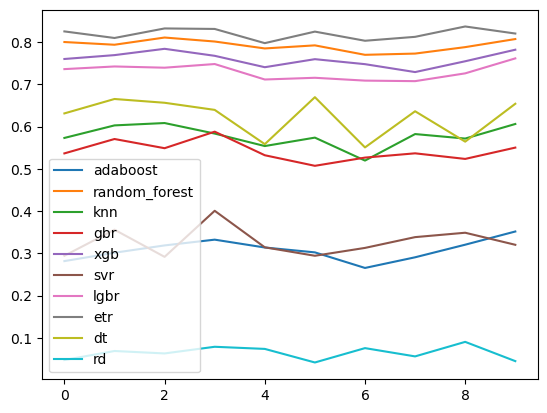

In [21]:
# Dataset Split to Train/Test data

X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(x_8, y_8, test_size = test_size, shuffle = shuffle)

models_8, r2_score_8, mae_score_8, rmse_score_8 = training(X_train_8, X_test_8, y_train_8, y_test_8)

#### Case 9 : hr, hrv, coherence, BM, sleep, temperature

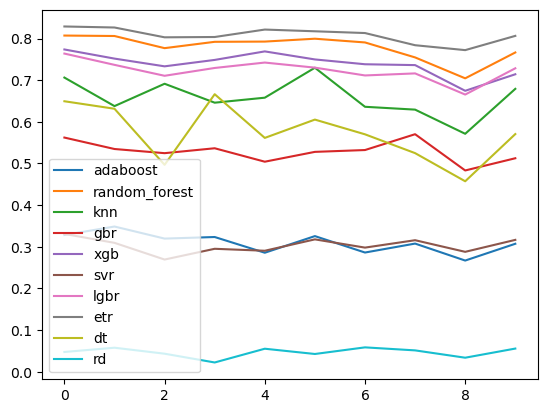

In [22]:
# Dataset Split to Train/Test data

X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(x_9, y_9, test_size = test_size, shuffle = shuffle)

models_9, r2_score_9, mae_score_9, rmse_score_9 = training(X_train_9, X_test_9, y_train_9, y_test_9)

### Score check

In [25]:
r2_scores = [r2_score_1, r2_score_2, r2_score_3, r2_score_4, r2_score_5, r2_score_6, r2_score_7, r2_score_8, r2_score_9]
mae_scores = [mae_score_1, mae_score_2, mae_score_3, mae_score_4, mae_score_5, mae_score_6, mae_score_7, mae_score_8, mae_score_9]
rmse_scores = [rmse_score_1, rmse_score_2, rmse_score_3, rmse_score_4, rmse_score_5, rmse_score_6, rmse_score_7, rmse_score_8, rmse_score_9]

# check R-Squared score for each case
for num, i in enumerate(r2_scores):
    print("r2_score_", num+1)
    arr = []
    for j in i:
        arr.append(j)
        print(j)
    print('Average : ', np.average(arr),"\n")
    
# check MAE score for each case
for num, i in enumerate(mae_scores):
    print("mae_score_", num+1)
    arr = []
    for j in i:
        arr.append(j)
        print(j)
    print('Average : ', np.average(arr),"\n")

# check RMSE score for each case
for num, i in enumerate(rmse_scores):
    print("rmse_score_", num+1)
    arr = []
    for j in i:
        arr.append(j)
        print(j)
    print('Average : ', np.average(arr),"\n")

r2_score_ 1
0.3436866745769142
0.8374322330591278
0.677969470055525
0.5497577061427633
0.8029268201797564
0.3755121048607327
0.7676531715241425
0.8677717971360452
0.7187116733361854
0.06338136055061368
Average :  0.6004803011421805 

r2_score_ 2
0.34149429441809315
0.8375263389375206
0.7101078100466313
0.5603077839933017
0.7986592286351495
0.3939549407819857
0.7642805050407746
0.8692285849582243
0.7079633641733885
0.06536294020167965
Average :  0.6048885791186749 

r2_score_ 3
0.2935525822306362
0.8121063475070928
0.6794296537402473
0.5154929269047513
0.7733776187224815
0.35288503307083696
0.7324577207029941
0.838620312657681
0.648338388415685
0.04561572027398073
Average :  0.5691876304226388 

r2_score_ 4
0.31868623036375865
0.81992762605639
0.669740616896173
0.5017316226600663
0.7762091169940303
0.2899686568227199
0.7344849590867834
0.846752826894507
0.690968032641885
0.0533511759287831
Average :  0.5701820864345095 

r2_score_ 5
0.24904659219451442
0.7581011109821587
0.6132518238059

---
## Evaluation with Test dataset

To check model's performance, user can print R-Squared score, MAE, RMSE

In [32]:
def model_tester(model, X_test, y_test):

    # y_label
    val_labels = np.expm1(y_test)
    # y_predict
    val_pred = np.expm1(model.predict(X_test))

    # comparison
    r2_scr_t = r2_score(val_labels, val_pred)
    mae_scr_t = mean_absolute_error(val_labels, val_pred)
    rmse_scr_t = mean_squared_error(val_labels, val_pred, squared=False)
        
    return model, r2_scr_t, mae_scr_t, rmse_scr_t

In [33]:
# put models in one list to print score easily
models = [models_1, models_2, models_3, models_4, models_5, models_6, models_7, models_8, models_9]
X_test = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5, X_test_6, X_test_7, X_test_8, X_test_9]
y_test = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5, y_test_6, y_test_7, y_test_8, y_test_9]

models_r2 = []
models_mae = []
models_rmse = []

# pile the results
for i in range(len(X_test)):
    for j in range(len(models[0])):
        model_result = model_tester(models[i][j], X_test[i], y_test[i])
        models_r2.append(model_result[1])
        models_mae.append(model_result[2])
        models_rmse.append(model_result[3])

In [34]:
# print R-Squared Score

for i in range(len(models_r2)):
    if i%10 == 0:
        print('---'*10)
    print(models_r2[i])

------------------------------
0.3793067045346873
0.8239085148681273
0.685951774175503
0.5569323287211959
0.7991328212138502
0.3938160736363374
0.760612988922863
0.8612303438055364
0.6952594140659615
0.06680880231471198
------------------------------
0.3216236018009314
0.8315276067865263
0.712526050198766
0.5492081113035336
0.7869825973708576
0.39051779255542374
0.7629708034452806
0.8681183537145798
0.6690026917241563
0.06781992912049561
------------------------------
0.31312337239924704
0.8113585033372293
0.6903702809256702
0.5113152394161622
0.7774232887251322
0.3503212524108824
0.7396181130555246
0.8426117646373045
0.6187814242993785
0.05039564388011708
------------------------------
0.3376250624103143
0.8240614911414313
0.6842724990404134
0.5156960963043415
0.7872769511292085
0.28913275556994056
0.7409208526723596
0.8521517935517073
0.703102979745096
0.048187366732260095
------------------------------
0.2491509654507742
0.770801258991578
0.6230520057175544
0.4472580199149657
0.7132

In [35]:
# print MAE Score

for i in range(len(models_mae)):
    if i%10 == 0:
        print('---'*10)
    print(models_r2[i])

------------------------------
0.3793067045346873
0.8239085148681273
0.685951774175503
0.5569323287211959
0.7991328212138502
0.3938160736363374
0.760612988922863
0.8612303438055364
0.6952594140659615
0.06680880231471198
------------------------------
0.3216236018009314
0.8315276067865263
0.712526050198766
0.5492081113035336
0.7869825973708576
0.39051779255542374
0.7629708034452806
0.8681183537145798
0.6690026917241563
0.06781992912049561
------------------------------
0.31312337239924704
0.8113585033372293
0.6903702809256702
0.5113152394161622
0.7774232887251322
0.3503212524108824
0.7396181130555246
0.8426117646373045
0.6187814242993785
0.05039564388011708
------------------------------
0.3376250624103143
0.8240614911414313
0.6842724990404134
0.5156960963043415
0.7872769511292085
0.28913275556994056
0.7409208526723596
0.8521517935517073
0.703102979745096
0.048187366732260095
------------------------------
0.2491509654507742
0.770801258991578
0.6230520057175544
0.4472580199149657
0.7132

In [36]:
# print RMSE Score

for i in range(len(models_rmse)):
    if i%10 == 0:
        print('---'*10)
    print(models_r2[i])

------------------------------
0.3793067045346873
0.8239085148681273
0.685951774175503
0.5569323287211959
0.7991328212138502
0.3938160736363374
0.760612988922863
0.8612303438055364
0.6952594140659615
0.06680880231471198
------------------------------
0.3216236018009314
0.8315276067865263
0.712526050198766
0.5492081113035336
0.7869825973708576
0.39051779255542374
0.7629708034452806
0.8681183537145798
0.6690026917241563
0.06781992912049561
------------------------------
0.31312337239924704
0.8113585033372293
0.6903702809256702
0.5113152394161622
0.7774232887251322
0.3503212524108824
0.7396181130555246
0.8426117646373045
0.6187814242993785
0.05039564388011708
------------------------------
0.3376250624103143
0.8240614911414313
0.6842724990404134
0.5156960963043415
0.7872769511292085
0.28913275556994056
0.7409208526723596
0.8521517935517073
0.703102979745096
0.048187366732260095
------------------------------
0.2491509654507742
0.770801258991578
0.6230520057175544
0.4472580199149657
0.7132